It seemed this endeavour was doomed to fail.

Only excitatory sigma values depend on `lambda_` as is, but this notebook was written to accomodate both depending on `lambda_` until the last part i.e. the part I used.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functions import *

import matplotlib.pyplot as plt

In [3]:
lambda_ = 0.8
sigma = get_sigma()

# I_syn = np.linspace(-800, 200, 500)*1e-12
I_syn_I = np.linspace(-800, -200, 1000)*1e-12
I_syn_E = np.linspace(-800, -300, 1000)*1e-12

I_syn = np.vstack([I_syn_E, I_syn_I]).T
# I_syn.shape

In [4]:
from functools import partial

idx = [0, -1]
phi_partial = partial(
    phi,
    g_m=g_m[idx],
    tau_m=tau_m[idx],
    tau_rp=tau_rp[idx]
)

phi_partial(I_syn[-1], sigma=sigma[0])  # returns E, I values

array([1.92085235e-08, 4.76775024e-15])

In [5]:
rates = np.empty((I_syn.shape[0], len(idx)))
for i, i_syn in enumerate(I_syn):
    rates[i, :] = phi_partial(i_syn, sigma=sigma[idx])

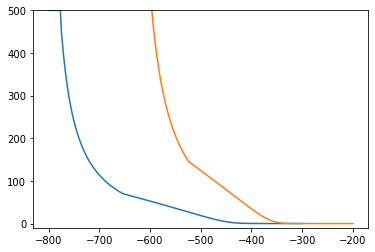

In [6]:
mask = rates.max(axis=1) <= 1000.

plt.plot(I_syn[mask, :] * 1e12, rates[mask, :])
plt.ylim(-10., 500.)

ymin,ymax = plt.ylim()
# plt.ylim(-10.0, 200.)

We can try to fit functions of the form

$$
\hat{\phi}(I, \sigma) := \frac{c(\sigma)I_{syn} - \overline{I}(\sigma) }{1 - \exp\left[-g(\sigma)\cdot (c(\sigma)I_{syn} - \overline{I}(\sigma)) \right]} \approx \phi(I, \sigma)
$$

where  $c, \overline{I}, g$ are given by polynomial expansions

$$
\begin{split}
c(s) = \sum_{k=0}^n a^c_k \cdot (b^c_k s)^k \\
\overline{I}(s) = \sum_{k=0}^n a^I_k \cdot (b^I_k s)^k \\
g(s) = \sum_{k=0}^n a^g_k \cdot (b^g_k s)^k \\
\end{split}
$$

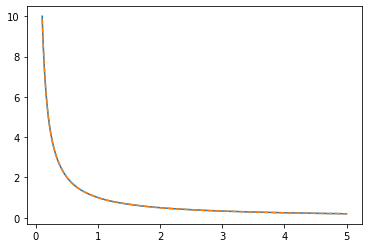

In [7]:
x = np.linspace(0.1, 5, 1000)
y = x**-1

coeff = np.polyfit(x, y, deg=20)

@jit(nopython=True)
def polyfunc(x, coeff=coeff):
    s = np.zeros_like(x)
    for n, c_ in enumerate(coeff[::-1]):
        s += c_ * (x**n)
    return s


y_hat = polyfunc(x)
plt.plot(x, y)
plt.plot(x, y_hat, '--');

In [8]:
# test_x = sigma_vals[0, :]
# test_y = 10*(test_x)**-5
# test_coeff = np.polyfit(test_x, test_y, deg=4)
# plt.plot(test_x, test_y)
# plt.plot(test_x, polyfunc(test_x, coeff=test_coeff))

In [9]:
@jit(nopython=True)
def phi_hat(I_syn, sigma, a_c, a_I, a_g):  #, b_c, b_I, b_g):
    c_sigma = polyfunc(sigma, coeff=a_c)
    I_sigma = polyfunc(sigma, coeff=a_I)
    g_sigma = polyfunc(sigma, coeff=a_g)
    
    numerator = c_sigma * (-I_syn) - I_sigma
    denominator = 1 - np.exp(-g_sigma * numerator)
    result = numerator / denominator
    return result
    
a_c = np.random.randn(10)
a_I = np.random.randn(10)
a_g = np.random.randn(10)



Alternatively, from attempts before we can try

$$
\begin{split}
c(s) = a_c \cdot s^{b_c} \\
\overline{I}(s) = a_\overline{I} \cdot s^{b_\overline{I}} \\
g(s) = a_g \cdot s^{b_g} \\
\end{split}
$$

In [10]:
@jit(nopython=True)
def phi_hat2(I_syn, sigma, a_c, a_I, a_g, b_c, b_I, b_g):
    c_sigma = a_c * (sigma**b_c)
    I_sigma = a_I * (sigma**b_I)
    g_sigma = a_g * (sigma**b_g)
    numerator = c_sigma * (-I_syn) - I_sigma
    denominator = 1 - np.exp(-g_sigma * numerator)
    result = numerator / denominator
    return result

In [11]:
%timeit phi_hat(i_syn, sigma[idx], a_c, a_I, a_g)

The slowest run took 5.52 times longer than the fastest. This could mean that an intermediate result is being cached.
8.18 µs ± 7.27 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%timeit phi_hat2(i_syn, sigma[idx], *a_c[:6])

The slowest run took 6.32 times longer than the fastest. This could mean that an intermediate result is being cached.
9.42 µs ± 9.15 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit phi_partial(i_syn, sigma=sigma[idx])

362 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


First we need to ensure functions like `1/x` are easily expressed this way.

Next we want to identify the bounds of fitting the functions.

In [14]:
def get_lowest_bound(rates, thresh=0.1):
    r_diff = np.diff(rates)
    conv = np.convolve(r_diff, [0.5, -1., 0.5], mode='valid')
    lowest_bound_idx = np.arange(conv.shape[0])[conv > thresh][-1]
    return lowest_bound_idx

(0.0, 0.1)

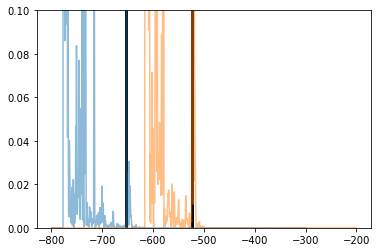

In [15]:
lowest_bound_idx = np.zeros(2, dtype=int)
for i in range(2):
    r_diff = np.diff(rates[:, i])
    conv = np.convolve(r_diff, [0.5,-1.,0.5], mode='valid')
#     lowest_bound_idx[i] = np.arange(conv.shape[0])[conv > 0.1][-1]
    lowest_bound_idx[i] = get_lowest_bound(rates[:, i])
    plt.plot(I_syn[:, i][2:-1] * 1e12, np.abs(conv), alpha=0.5)
plt.vlines(
    I_syn[lowest_bound_idx, [0, 1]] * 1e12, 0.0, 0.1,
    color='k', lw=3)
plt.ylim(0.0, 0.1)

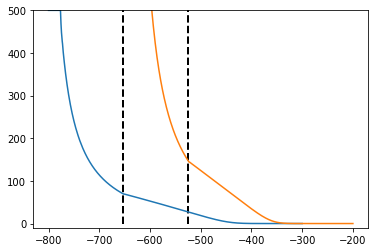

In [16]:
mask = rates.max(axis=1) <= 1000.

plt.plot(I_syn[mask, :] * 1e12, rates[mask, :])
plt.ylim(-10., 500.)

plt.vlines(
    I_syn[lowest_bound_idx, [0, 1]] * 1e12, 0.0, 500.,
    color='k', lw=2, ls='--')

Now we set up the evolutionary algorithm to find parameters as we vary sigma by varying lambda_.  
We need to fit two functions, one for excitatory and one for inhibitory population parameters.

In [17]:
num_lambda = 10
lambda_vals = np.linspace(0., 1., num_lambda)

sigma_vals = np.zeros((2, num_lambda))
for i in range(num_lambda):
    sigma_vals[:, i] = get_sigma(lambda_vals[i])[idx]
    
I_syn_vec = np.linspace(-800, -200, 1000)*1e-12

In [18]:
phi_partial(i_syn[0], sigma=sigma_vals[:, 0])

array([2.50663942e-16, 3.76193017e-03])

For each type (E/I) we create multiple phi vectors, one for each sigma value. The fitness is then the maximum of the differences between the approximated phi and the true phi on the range where it is well defined.

In [19]:
# slow cell
true_rates_E = np.zeros((num_lambda, I_syn_vec.shape[0]))
true_rates_I = np.zeros((num_lambda, I_syn_vec.shape[0]))

lower_bounds_E = np.zeros(num_lambda, dtype=int)
lower_bounds_I = np.zeros(num_lambda, dtype=int)

for i in range(true_rates_E.shape[0]):
    for j in range(true_rates_E.shape[1]):
        true_rates = phi_partial(
            I_syn_vec[j],
            sigma=sigma_vals[:, i])
        true_rates_E[i,j] = true_rates[0]
        true_rates_I[i,j] = true_rates[1]
    lower_bounds_E[i] = get_lowest_bound(true_rates_E[i,:])
    lower_bounds_I[i] = get_lowest_bound(true_rates_I[i,:])

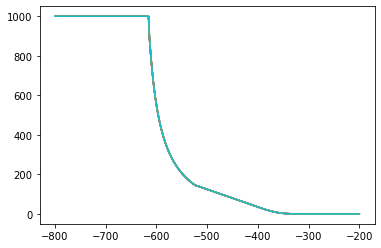

In [20]:
for m in range(num_lambda):
    plt.plot(I_syn_vec * 1e12, true_rates_I[m, :])

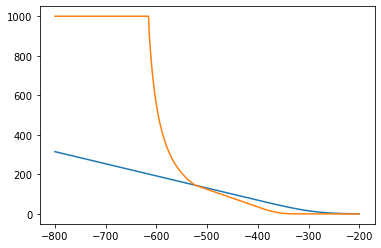

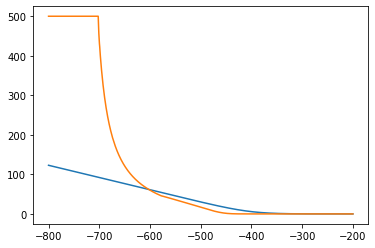

In [21]:
c_gain = np.array([310.] + [615.]) * (1e9)
I_thr =  np.array([125.] + [177.])
g_noise =  np.array([0.16] + [0.087])

def phi_wongwang(I_syn):
    numerator = c_gain * (-I_syn) - I_thr
    denominator = 1 - np.exp(-g_noise*(numerator))
    return numerator / denominator

ww_rates = phi_wongwang(
    np.vstack([I_syn_vec, I_syn_vec]).T
)

plt.figure()
# plt.plot(I_syn_vec*1e12, ww_rates[:, 0])
plt.plot(I_syn_vec*1e12, ww_rates[:, 1])
plt.plot(I_syn_vec * 1e12, true_rates_I[0, :])
plt.figure()
plt.plot(I_syn_vec*1e12, ww_rates[:, 0])
plt.plot(I_syn_vec * 1e12, true_rates_E[0, :])
# plt.plot(I_syn[mask, :] * 1e12, rates[mask, :])
# plt.ylim(-10., 500.)

We set up the fitness function as being the maximum of the difference of values across all settings of sigma.

In [22]:
# polfit = np.polyfit(I_syn_vec, true_rates_E[0, :], deg=15)
# plt.plot(I_syn_vec*1e12, polyfunc(I_syn_vec, coeff=polfit))
# plt.plot(I_syn_vec*1e12, true_rates_E[0, :])

In [23]:
degree = 14

def get_approximate_rates(genome, mode='E', approx_func=2):
    if mode == 'E':
        sigma_row = 0
    elif mode == 'I':
        sigma_row = 1
    rates_approx = np.zeros((num_lambda, I_syn_vec.shape[0]))
    if approx_func == 1:
        a_c = genome[:degree]
        a_I = genome[degree:2*degree]
        a_g = genome[2*degree:]
        for i in range(num_lambda):
            rates_approx[i, :] = phi_hat(
                I_syn_vec, sigma_vals[sigma_row, i],
                a_c, a_I, a_g
            )
    elif approx_func == 2:
        a_c = genome[0]
        a_I = genome[1]
        a_g = genome[2]
        b_c = genome[3]
        b_I = genome[4]
        b_g = genome[5]
        for i in range(num_lambda):
            rates_approx[i, :] = phi_hat2(
                I_syn_vec, sigma_vals[sigma_row, i],
                a_c, a_I, a_g, b_c, b_I, b_g
            )
#     if mode == 'E':
#         rates_approx[rates_approx > 1/tau_rp_E] = 1/tau_rp_E
#     if mode == 'I':
#         rates_approx[rates_approx > 1/tau_rp_I] = 1/tau_rp_I
#     rates_approx[rates_approx < 0.] = 0.
    return rates_approx


max_rate_fitting = 120.
m_E = (true_rates_E < max_rate_fitting) & (true_rates_E > 1.)
m_I = (true_rates_I < max_rate_fitting) & (true_rates_I > 1.)
def fitness(genome, mode='E', approx_func=2, power=2):
    rates_approx = get_approximate_rates(
        genome,
        mode=mode,
        approx_func=approx_func
    )
    if np.any(np.isnan(rates_approx) | np.isinf(rates_approx)):
        return np.inf,
    
    if mode == 'E':
        fitness_score = np.mean(np.abs(true_rates_E - rates_approx)[m_E]**power)
    if mode == 'I':
        fitness_score = np.mean(np.abs(true_rates_I - rates_approx)[m_I]**power)
    
#     fitness_score = 0.
#     for i in range(num_lambda):
#         if mode == 'E':
#             score_array = np.abs(true_rates_E - rates_approx)[
#                 i, :
# #                 lower_bounds_E[i]:
#             ]
#         if mode == 'I':
#             score_array = np.abs(true_rates_I - rates_approx)[
#                 i, :
# #                 lower_bounds_I[i]:
#             ]
#         fitness_score += np.mean(score_array**2)
#         fitness_score = max(fitness_score, np.max(score_array))
    return fitness_score,

power = 2

fitness_E1 = partial(fitness, mode='E', approx_func=1, power=power)
fitness_I1 = partial(fitness, mode='I', approx_func=1, power=power)

fitness_E2 = partial(fitness, mode='E', approx_func=2, power=power)
fitness_I2 = partial(fitness, mode='I', approx_func=2, power=power)

Now we run the evolutionary algorithm.

In [31]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
from deap import cma

In [32]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# IND_SIZE = degree * 3
# IND_SIZE2 = 6
NGEN = 10000

In [33]:
# for E param
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

centroid_E1 = [c_gain[0]] + [0.0]*(degree-1)
centroid_E1 += [I_thr[0]] + [0.0]*(degree-1)
centroid_E1 += [g_noise[0]] + [0.0]*(degree-1)
centroid_I1 = [c_gain[1]] + [0.0]*(degree-1)
centroid_I1 += [I_thr[1]] + [0.0]*(degree-1)
centroid_I1 += [g_noise[1]] + [0.0]*(degree-1)

centroid_E2 = [c_gain[0], I_thr[0], g_noise[0]] + [0.0]*3
centroid_I2 = [c_gain[1], I_thr[1], g_noise[1]] + [0.0]*3

# each run needs its own toolbox
# hof_E1 = tools.HallOfFame(20)
# toolbox_E1 = base.Toolbox()
# toolbox_E1.register("evaluate", fitness_E1)
# strategy_E1 = cma.Strategy(
#     centroid = centroid_E1, sigma=20.0
# )
# toolbox_E1.register("generate", strategy_E1.generate, creator.Individual)
# toolbox_E1.register("update", strategy_E1.update)

# hof_E2 = tools.HallOfFame(20)
# toolbox_E2 = base.Toolbox()
# toolbox_E2.register("evaluate", fitness_E2)
# strategy_E2 = cma.Strategy(
#     centroid=centroid_E2, sigma=5.0
# )
# toolbox_E2.register("generate", strategy_E2.generate, creator.Individual)
# toolbox_E2.register("update", strategy_E2.update)

In [34]:
starting_sigmas_EA = np.logspace(np.log10(5.), np.log10(200.), 20)

In [36]:
from numpy.linalg import LinAlgError
from tqdm.notebook import tqdm

hof_E1 = tools.HallOfFame(20)
toolbox_E1 = base.Toolbox()
toolbox_E1.register("evaluate", fitness_E1)
for run, starting_sigma in enumerate(tqdm(starting_sigmas_EA)):
    strategy_E1 = cma.Strategy(
        centroid=centroid_E1,
        sigma=starting_sigma
    )
    toolbox_E1.register("generate", strategy_E1.generate, creator.Individual)
    toolbox_E1.register("update", strategy_E1.update)
    try:
        pop, logbook = algorithms.eaGenerateUpdate(
            toolbox_E1,
            ngen=NGEN, stats=stats, halloffame=hof_E1,
            verbose=False
        )
    except LinAlgError as e:
        print(f"LinAlgError: procedure halted on run {run}")

  0%|          | 0/20 [00:00<?, ?it/s]

In [35]:
hof_E2 = tools.HallOfFame(20)
toolbox_E2 = base.Toolbox()
toolbox_E2.register("evaluate", fitness_E2)
for run, starting_sigma in enumerate(tqdm(starting_sigmas_EA)):
    strategy_E2 = cma.Strategy(
        centroid=centroid_E2,
        sigma=starting_sigma
    )
    toolbox_E2.register("generate", strategy_E2.generate, creator.Individual)
    toolbox_E2.register("update", strategy_E2.update)
    try:
        pop, logbook = algorithms.eaGenerateUpdate(
            toolbox_E2,
            ngen=NGEN, stats=stats, halloffame=hof_E2,
            verbose=False
        )
    except LinAlgError as e:
        print(f"LinAlgError: procedure halted on run {run}")

  0%|          | 0/20 [00:00<?, ?it/s]

LinAlgError: procedure halted on run 0
LinAlgError: procedure halted on run 1
LinAlgError: procedure halted on run 2
LinAlgError: procedure halted on run 3
LinAlgError: procedure halted on run 4
LinAlgError: procedure halted on run 5
LinAlgError: procedure halted on run 6
LinAlgError: procedure halted on run 7
LinAlgError: procedure halted on run 8
LinAlgError: procedure halted on run 9
LinAlgError: procedure halted on run 10
LinAlgError: procedure halted on run 11
LinAlgError: procedure halted on run 12
LinAlgError: procedure halted on run 13
LinAlgError: procedure halted on run 14
LinAlgError: procedure halted on run 15
LinAlgError: procedure halted on run 16
LinAlgError: procedure halted on run 17
LinAlgError: procedure halted on run 18
LinAlgError: procedure halted on run 19


In [59]:
hof_I1 = tools.HallOfFame(20)
toolbox_I1 = base.Toolbox()
toolbox_I1.register("evaluate", fitness_I1)
for run, starting_sigma in enumerate(tqdm(starting_sigmas_EA)):
    strategy_I1 = cma.Strategy(
        centroid=centroid_I1,
        sigma=starting_sigma
    )
    toolbox_I1.register("generate", strategy_I1.generate, creator.Individual)
    toolbox_I1.register("update", strategy_I1.update)
    try:
        pop, logbook = algorithms.eaGenerateUpdate(
            toolbox_I1,
            ngen=NGEN, stats=stats, halloffame=hof_I1,
            verbose=False
        )
    except LinAlgError as e:
        print(f"LinAlgError: procedure halted on run {run}")

  0%|          | 0/20 [00:00<?, ?it/s]

In [60]:
hof_I2 = tools.HallOfFame(20)
toolbox_I2 = base.Toolbox()
toolbox_I2.register("evaluate", fitness_I2)
for run, starting_sigma in enumerate(tqdm(starting_sigmas_EA)):
    strategy_I2 = cma.Strategy(
        centroid=centroid_I2,
        sigma=starting_sigma
    )
    toolbox_I2.register("generate", strategy_I2.generate, creator.Individual)
    toolbox_I2.register("update", strategy_I2.update)
    try:
        pop, logbook = algorithms.eaGenerateUpdate(
            toolbox_I2,
            ngen=NGEN, stats=stats, halloffame=hof_I2,
            verbose=False
        )
    except LinAlgError as e:
        print(f"LinAlgError: procedure halted on run {run}")

  0%|          | 0/20 [00:00<?, ?it/s]

LinAlgError: procedure halted on run 0
LinAlgError: procedure halted on run 1
LinAlgError: procedure halted on run 2
LinAlgError: procedure halted on run 3
LinAlgError: procedure halted on run 4
LinAlgError: procedure halted on run 5
LinAlgError: procedure halted on run 6
LinAlgError: procedure halted on run 7
LinAlgError: procedure halted on run 8
LinAlgError: procedure halted on run 9
LinAlgError: procedure halted on run 10
LinAlgError: procedure halted on run 11
LinAlgError: procedure halted on run 12
LinAlgError: procedure halted on run 13
LinAlgError: procedure halted on run 14
LinAlgError: procedure halted on run 15
LinAlgError: procedure halted on run 16
LinAlgError: procedure halted on run 17
LinAlgError: procedure halted on run 18
LinAlgError: procedure halted on run 19


In [70]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
def anim_func(i):
    sig_idx = int(i/len(hof_E1))
    i = i % sigma_vals.shape[1]
    axes[0].clear()
    axes[1].clear()
    y_hat1 = phi_hat(
        I_syn_vec, sigma_vals[0, sig_idx],
        hof_E1[i][:degree],
        hof_E1[i][degree:2*degree],
        hof_E1[i][2*degree:],
    )
    y_hat2 = phi_hat2(
        I_syn_vec, sigma_vals[0, sig_idx],
        *hof_E2[i]
    )
    axes[0].plot(
        I_syn_vec * 1e12,
        y_hat1, '--',
        label='poly'
    )
    axes[0].plot(
        I_syn_vec * 1e12,
        y_hat2, '-.',
        label='old'
    )
    axes[0].plot(
        I_syn_vec * 1e12,
        true_rates_E[sig_idx, :],
        label='true'
    )
    axes[0].legend(title='fit')
    axes[0].set_ylim(0, 120)
    axes[0].set_xlim(-800, -350)
    axes[0].set_title(f'Excitatory\n$\sigma$={sigma_vals[0, sig_idx]}')
    
    y_hat1 = phi_hat(
        I_syn_vec, sigma_vals[1, sig_idx],
        hof_I1[i][:degree],
        hof_I1[i][degree:2*degree],
        hof_I1[i][2*degree:],
    )
    y_hat2 = phi_hat2(
        I_syn_vec, sigma_vals[1, sig_idx],
        *hof_I2[i]
    )
    axes[1].plot(
        I_syn_vec * 1e12,
        y_hat1, '--',
        label='poly'
    )
    axes[1].plot(
        I_syn_vec * 1e12,
        y_hat2, '-.',
        label='old'
    )
    axes[1].plot(
        I_syn_vec * 1e12,
        true_rates_E[sig_idx, :],
        label='true'
    )
    axes[1].legend(title='fit')
    axes[1].set_ylim(0, 120)
    axes[1].set_xlim(-800, -350)
    axes[1].set_title(f'Inhibitory\n$\sigma$={sigma_vals[1, sig_idx]}')

ani = FuncAnimation(
    fig, anim_func,
    frames=np.arange(len(hof_E1) * sigma_vals.shape[1])
)
plt.close()

In [71]:
HTML(ani.to_html5_video())

In [63]:
from datetime import datetime
import pickle

with open(f'hof_E1_{datetime.now()}.pkl', 'wb') as f:
    pickle.dump(hof_E1, f)
with open(f'hof_E2_{datetime.now()}.pkl', 'wb') as f:
    pickle.dump(hof_E2, f)
    
with open(f'hof_I1_{datetime.now()}.pkl', 'wb') as f:
    pickle.dump(hof_I1, f)
with open(f'hof_I2_{datetime.now()}.pkl', 'wb') as f:
    pickle.dump(hof_I2, f)

(-830.0, -350.0)

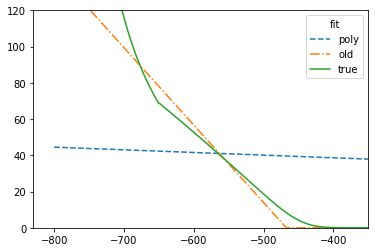

In [42]:
# sig_idx = 7

# best_params_E1 = sorted(hof_E1, key=lambda x: x.fitness)[0]
# best_params_E2 = sorted(hof_E2, key=lambda x: x.fitness)[0]

# y_hat1 = phi_hat(
#     I_syn_vec, sigma_vals[0, sig_idx],
# #     centroid_E1[:degree],
# #     centroid_E1[degree:2*degree],
# #     centroid_E1[2*degree:],
#     best_params_E1[:degree],
#     best_params_E1[degree:2*degree],
#     best_params_E1[2*degree:],
# )
# y_hat2 = phi_hat2(
#     I_syn_vec, sigma_vals[0, sig_idx],
# #     *centroid_E2,
#     *best_params_E2,
# )

# plt.plot(
#     I_syn_vec * 1e12,
#     y_hat1, '--',
#     label='poly'
# )
# plt.plot(
#     I_syn_vec * 1e12,
#     y_hat2, '-.',
#     label='old'
# )
# plt.plot(
#     I_syn_vec * 1e12,
#     true_rates_E[sig_idx, :],
#     label='true'
# )
# plt.legend(title='fit')
# plt.ylim(0, 120)
# xl, xh = plt.xlim()
# plt.xlim(xl, -350)

Two more plans of attack to speed this thing up:

1. approximate `erf` with a numba-friendly function for faster integration
2. fit parameters for various values of sigma, then fit curves to those parameters

Method 1:

In [158]:
from functions import _rate_upperbound_vectorised, _rate_lowerbound_vectorised, _siegert_integrand
from numba import njit

@njit
def erf_approx(x):
    """
    Abramowitz and Stegun approximation.
    
    But this ends up being slower.
    """
    denominator = np.empty_like(x)
    result = np.empty_like(x)
    positive_mask = x >= 0
    denominator[positive_mask] = (
        1+0.278393*x[positive_mask] \
        +0.230389*x[positive_mask]**2 \
        + 0.000972*x[positive_mask]**3 \
        + 0.078108*x[positive_mask]**4 )**4
    denominator[~positive_mask] = (
        1+0.278393*(-x[~positive_mask]) \
        +0.230389*(-x[~positive_mask])**2 \
        + 0.000972*(-x[~positive_mask])**3 \
        + 0.078108*(-x[~positive_mask])**4 )**4
    result = 1. - 1./denominator
    result[~positive_mask] = -result[~positive_mask]
    return result
     

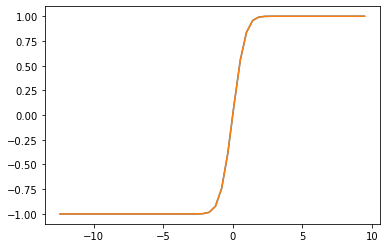

In [152]:
V_SS_E = V_L - I_syn_vec/g_m_E
V_SS_I = V_L - I_syn_vec/g_m_I

upper_E = _rate_upperbound_vectorised(V_SS_E, sigma_vals[0, :].min(), tau_m_E, tau_rp_E).max()
lower_E = _rate_lowerbound_vectorised(V_SS_E, sigma_vals[0, :].min()).min()

upper_I = _rate_upperbound_vectorised(V_SS_I, sigma_vals[1, :].min(), tau_m_E, tau_rp_E).max()
lower_I = _rate_lowerbound_vectorised(V_SS_I, sigma_vals[1, :].min()).min()

upper_erf_bound = max(upper_E, upper_I)
lower_erf_bound = max(lower_E, lower_I)
erf_inputs = np.linspace(lower_erf_bound, upper_erf_bound, 50)

plt.plot(erf_inputs, special.erf(erf_inputs))
plt.plot(erf_inputs, erf_approx(erf_inputs))

In [156]:
%timeit special.erf(erf_inputs)

1.6 µs ± 21.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [157]:
%timeit erf_approx(erf_inputs)

3.15 µs ± 13.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Method 2:

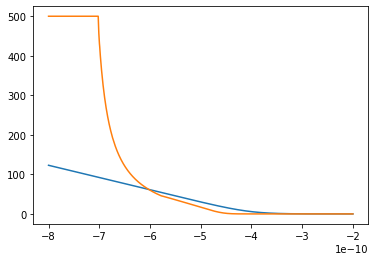

In [341]:
from scipy.optimize import fmin

# c_gain = np.array([310.] + [615.]) * (1e9)
# I_thr =  np.array([125.] + [177.])
# g_noise =  np.array([0.16] + [0.087])

c=310.*1e9
I=125.
g=0.16
@njit
def phi_fit(
    I_syn,
    c=c,
    I=I,
    g=g
):
    numerator = c * (-I_syn) - I
    denominator = 1 - np.exp(-g*(numerator))
    return numerator / denominator

plt.plot(I_syn_vec, phi_fit(I_syn_vec))

for sigma in set(sigma_vals.ravel()):
    rates_E = np.zeros_like(I_syn_vec)
    for i, i_syn in enumerate(I_syn_vec):
        rates_E[i] = phi_partial(i_syn, sigma=sigma)[0]
    plt.plot(I_syn_vec, rates_E)
    break

In [342]:
best_cIg = np.zeros((true_rates_E.shape[0], 3))

upper_fit = 200.
lower_fit = 0.1
for sig_idx in tqdm(np.arange(true_rates_E.shape[0])):
    rates_E = true_rates_E[sig_idx, :]
    mask = (rates_E < upper_fit) & (rates_E > lower_fit)
    sigma = sigma_vals[0, sig_idx]
    
    def f_test(cIg):
        c, I, g = cIg
        est = phi_fit(I_syn_vec, c, I, g)
        return np.mean((rates_E-est)[mask]**2)
    
    cIg_res = fmin(f_test, x0=np.array([c, I, g]))
    best_cIg[sig_idx, :] = cIg_res

  0%|          | 0/10 [00:00<?, ?it/s]

In [343]:
fig, ax = plt.subplots()

def anim_func(sig_idx):
    ax.clear()
    c,I,g = best_cIg[sig_idx, :]
    rates_E = true_rates_E[sig_idx, :]
#     mask = (rates_E < 200.) & (rates_E > 0.1)
    mask = np.full_like(rates_E, True, dtype=bool)
    phi_fit_vals = phi_fit(I_syn_vec, c,I,g)
    ax.plot(I_syn_vec[mask], phi_fit_vals[mask], label='fitted')
    ax.plot(I_syn_vec[mask], rates_E[mask], label='true')
    ax.legend(title=f'$\sigma={sigma_vals[0, sig_idx]*1000:.3f}$mV')
    

ani = FuncAnimation(
    fig, anim_func,
    frames=np.arange(best_cIg.shape[0])
)
plt.close()

In [344]:
HTML(ani.to_html5_video())

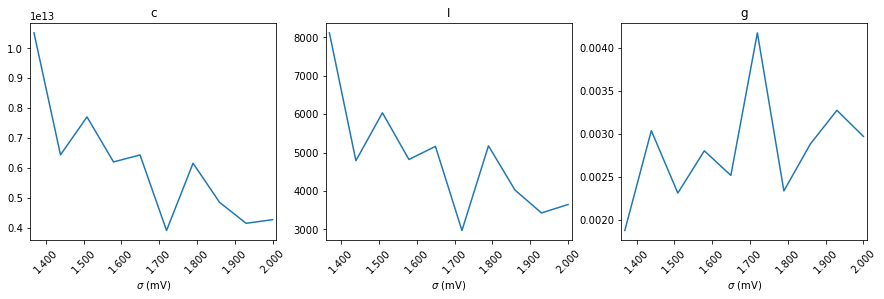

In [345]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
label = 'cIg'
for i in range(3):
    ax[i].plot(sigma_vals[0, :]*1000, best_cIg[:,i])
    ax[i].set_title(label[i])
    ax[i].set_xticks(ax[i].get_xticks())
    ax[i].set_xticklabels(
        labels=[f'{x:.3f}' for x in ax[i].get_xticks()],
        rotation=45
    )
    ax[i].set_xlim(
        (sigma_vals[0, :]*1000).min()-0.01,
        (sigma_vals[0, :]*1000).max()+0.01
    )
    ax[i].set_xlabel('$\sigma$ (mV)')

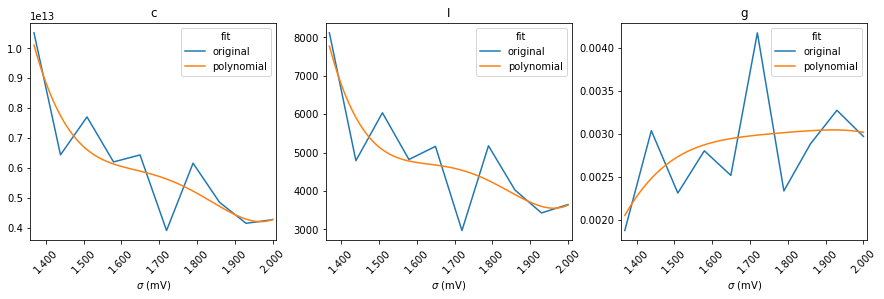

In [346]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

degree = 4
polyfit_coeffs = np.zeros((best_cIg.shape[0], degree+1))
for i in range(3):
    polyfit_coeffs[i, :] = np.polyfit(sigma_vals[0,:], best_cIg[:,i], deg=4)

for i in range(3):
    polyfit_coeff = polyfit_coeffs[i, :]
    poly_fit_sigma = np.linspace(sigma_vals[0,:].min(), sigma_vals[0,:].max(), 100)
    polyfit_vals = polyfunc(poly_fit_sigma, coeff=polyfit_coeff)
    
    ax[i].plot(1000.*sigma_vals[0,:], best_cIg[:,i], label='original')
    ax[i].plot(1000.*poly_fit_sigma, polyfit_vals, label='polynomial')
    ax[i].legend(title='fit')
    ax[i].set_title(label[i])
    ax[i].set_xticks(ax[i].get_xticks())
    ax[i].set_xticklabels(
        labels=[f'{x:.3f}' for x in ax[i].get_xticks()],
        rotation=45
    )
    ax[i].set_xlim(
        (sigma_vals[0, :]*1000).min()-0.01,
        (sigma_vals[0, :]*1000).max()+0.01
    )
    ax[i].set_xlabel('$\sigma$ (mV)')
#     plt.plot(sigma_vals[0,:], best_cIg[:,0])
#     plt.plot(sigma_vals[0,:], polyfit_vals)

In [347]:
np.save('polyfit_coeffs_excitatory.npy', polyfit_coeffs)

In [348]:
fig, axes = plt.subplots(1, 2, figsize=(12,6), sharey=True)

def anim_func(sig_idx):
    rates_E = true_rates_E[sig_idx, :]
    mask = (rates_E < 200.) & (rates_E > 0.1)
#     mask = np.full_like(rates_E, True, dtype=bool)
    
    axes[0].clear()
    c,I,g = best_cIg[sig_idx, :]
    phi_fit_vals = phi_fit(I_syn_vec, c,I,g)
    axes[0].plot(I_syn_vec[mask], phi_fit_vals[mask], label='fitted')
    axes[0].plot(I_syn_vec[mask], rates_E[mask], label='true')
    axes[0].legend(title=f'$\sigma={sigma_vals[0, sig_idx]*1000:.3f}$mV')
    axes[0].set_title("fmin-fitted")

    axes[1].clear()
    c = polyfunc(sigma_vals[0, sig_idx], coeff=polyfit_coeffs[0, :])
    I = polyfunc(sigma_vals[0, sig_idx], coeff=polyfit_coeffs[1, :])
    g = polyfunc(sigma_vals[0, sig_idx], coeff=polyfit_coeffs[2, :])
    phi_fit_vals = phi_fit(I_syn_vec, c,I,g)
    axes[1].plot(I_syn_vec[mask], phi_fit_vals[mask], label='fitted')
    axes[1].plot(I_syn_vec[mask], rates_E[mask], label='true')
    axes[1].legend(title=f'$\sigma={sigma_vals[0, sig_idx]*1000:.3f}$mV')
    axes[1].set_title("polyfitted")
    

ani = FuncAnimation(
    fig, anim_func,
    frames=np.arange(best_cIg.shape[0])
)
plt.close()

In [349]:
HTML(ani.to_html5_video())

In [350]:
from functions import phi

sig_idx = 5

%timeit phi(I_syn_vec, g_m_E, sigma_vals[0, sig_idx], tau_m_E, tau_rp_E)

3.93 s ± 48.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [351]:
%%timeit
c = polyfunc(sigma_vals[0, sig_idx], coeff=polyfit_coeffs[0, :])
I = polyfunc(sigma_vals[0, sig_idx], coeff=polyfit_coeffs[1, :])
g = polyfunc(sigma_vals[0, sig_idx], coeff=polyfit_coeffs[2, :])
phi_fit(I_syn_vec, c,I,g)

21.6 µs ± 385 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Now fit the inhibitory neurons, which don't have varying sigma vals.

In [357]:
np.diff(true_rates_I, axis=0)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Optimization terminated successfully.
         Current function value: 19.054338
         Iterations: 173
         Function evaluations: 346


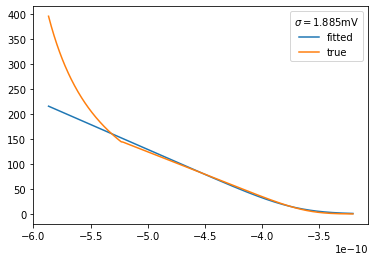

In [361]:
upper_fit = 200.
lower_fit = 0.1

rates_I = true_rates_I[0, :]
mask = (rates_I < upper_fit) & (rates_I > lower_fit)
sigma = sigma_vals[1, 0]

def f_test(cIg):
    c, I, g = cIg
    est = phi_fit(I_syn_vec, c, I, g)
    return np.mean((rates_I-est)[mask]**2)

best_cIg_I = fmin(f_test, x0=np.array([c, I, g]))

fig, ax = plt.subplots()

c,I,g = best_cIg_I
mask = (rates_I < 400.) & (rates_I > 0.1)
# mask = np.full_like(rates_I, True, dtype=bool)

phi_fit_vals = phi_fit(I_syn_vec, c,I,g)
ax.plot(I_syn_vec[mask], phi_fit_vals[mask], label='fitted')
ax.plot(I_syn_vec[mask], rates_I[mask], label='true')
ax.legend(title=f'$\sigma={sigma*1000:.3f}$mV')

In [362]:
np.save('direct_fit_inhibitory.npy', best_cIg_I)